# Wrapping dependent libraries

**StructureAnalysis** is a set of libraries that include statistical models for the analysis of structured data (mainly sequences and tree-structured data):

* **StatTool** is a library containing classes concerning parametric  modeling of univariate and multivariate data.

* **SequenceAnalysis** is a library containing statistical functions and classes for markovian models (e.g., hidden variable-order Markov and hidden semi-Markov models) and multiple change-point models for sequences.
  The **SequenceAnalysis** library depends on the **StatTool** library.

These libraries have been extensively used for the identification and characterization of developmental patterns in plants from the tissular to the whole plant scale.
Previously interfaced with *AML* (a home-made, domain-specific programming language), some work has been done to switch to *Python*.
Nevertheless, the complexity of writing wrappers with **Boost.Python** limited the number of available components in *Python* in comparison to *AML*.
One advantage of having a statistical library written in *C++* available in *Python* is that developers can benefit from all *Python* packages.
As illustrated with the following figures this is particularly useful for providing visualizations for model quality assessment using -- for example -- the **Matplotlib** *Python* package.

In [1]:
import matplotlib
%matplotlib nbagg

We here aim at presenting how dependent libraries can be wrapped.
First, we need:

* to detect if the operating system (OS) is a Windows OS or a Unix OS.

In [2]:
import platform
is_windows = any(platform.win32_ver())

On Windows OSes, the visual studio version used to compile future wrappers must be given.

In [3]:
if is_windows:
    kwargs = dict(msvc_version = '12.0')
else:
    kwargs = dict()

* to detect the version of *Python* installed and to save it in the `PYTHON_VERSION` environment variable.

In [4]:
import os
import sys
PYTHON_VERSION = str(sys.version_info.major) + '.' + str(sys.version_info.minor)

* to import **AutoWIG**.

In [5]:
import autowig

* to import **subprocess**.

In [6]:
import subprocess

* to detect the **Git** repository root

In [7]:
import os
GIT_ROOT = subprocess.check_output('git rev-parse --show-toplevel', shell=True).decode()
GIT_ROOT = GIT_ROOT.replace('/', os.sep).strip()

## The **StatTool** library

To compile and install the **StatTool** library, we use the available **Conda** recipes.

In [8]:
subprocess.call('conda remove -y libstat_tool', shell=True)
CONDA_RECIPE = os.path.join(GIT_ROOT, 'share', 'git', 'StructureAnalysis', 'stat_tool', 'bin', 'conda',
                            'libstat_tool')
subprocess.check_call('conda build --python=' + PYTHON_VERSION + ' ' + CONDA_RECIPE + ' -c statiskit -c defaults --override-channels',
                      shell=True)
subprocess.check_call('conda install -y libstat_tool --use-local -c statiskit -c defaults --override-channels',
                      shell=True)

0

Then, we can proceed to the actual generation of wrappers for the **StatTool** library.
For this, we create an empty Abstract Semantic Graph (ASG).

In [9]:
import autowig
asg = autowig.AbstractSemanticGraph()

Then, we parse headers with relevant compilation flags.

In [10]:
%%time

import sys
try:
    from path import Path
except:
    from path import path as Path
prefix = Path(sys.prefix).abspath()
if is_windows:
    headers = list((prefix/'include'/'stat_tool').walkfiles('*.h'))
else:
    headers = list((prefix/'include'/'stat_tool').walkfiles('*.h'))
    
flags = ['-x', 'c++', '-std=c++11', '-stdlib=libstdc++', '-ferror-limit=0']#, '-msse', '-msse2']
flags = ['-x', 'c++', '-std=c++11', '-ferror-limit=0']#, '-msse', '-msse2']
if is_windows:
    flags.append('-I' + str((prefix/'Library'/'include').abspath()))
else:
    flags.append('-I' + str((prefix/'include').abspath()))
    
if autowig.parser.plugin == 'libclang':
    kwargs['silent'] = True
    
autowig.parser.plugin = 'clanglite'
asg = autowig.parser(asg, headers,
                          flags = flags,
                          bootstrap = 2,
                          **kwargs)

/home/main/.miniconda/envs/fp17/lib/python2.7/site-packages/clanglite/autowig_parser.py:858: Warning: 
  warnings.warn('', Warning)
/home/main/.miniconda/envs/fp17/lib/python2.7/site-packages/clanglite/autowig_parser.py:860: Warning: FIRST_FUNCTION
  warnings.warn(str(kind), Warning)


CPU times: user 2min 27s, sys: 1.49 s, total: 2min 28s
Wall time: 2min 28s


Since most of **AutoWIG** guidelines are respected, the `default` `controller` implementation could be suitable.
Nevertheless, some **AutoWIG** limitations (**AutoWIG** doesn't have a complete knowledge concerning copyable classes) and the requirement of classes defined in the standard *C++* library lead us to implement a new `controller`.

In [11]:
def stat_tool_controller(asg):
    for noncopyable in ['class ::std::basic_streambuf< char, struct ::std::char_traits< char > >',
                        'class ::std::codecvt< char, char, __mbstate_t >',
                        'class ::std::locale::facet',
                        'class ::std::locale::id',
                        'class ::std::ctype< char >',
                        'class ::std::ios_base',
                        'class ::std::basic_istream< char, struct ::std::char_traits< char > >',
                        'class ::std::basic_ostream< char, struct ::std::char_traits< char > >',
                        'class ::std::basic_ostringstream< char, struct ::std::char_traits< char >, class ::std::allocator< char > >',
                        'class ::std::basic_ios< char, struct ::std::char_traits< char > >',
                        'class ::std::basic_stringbuf< char, struct ::std::char_traits< char >, class ::std::allocator< char > >']:
        if noncopyable in asg:
            asg[noncopyable].is_copyable = False
    for cls in asg.classes():
        for fld in cls.fields(access='public'):
            if fld.qualified_type.unqualified_type.globalname == 'class ::std::locale::id':
                fld.boost_python_export = False
    for template in ['class ::std::initializer_list',
                     'class ::std::reverse_iterator',
                     'class ::std::move_iterator',
                     'class ::std::allocator']:
        for specialization in asg[template].specializations():
            specialization.boost_python_export = False
    for template in ['class ::std::basic_ios',
                     'class ::std::basic_string']:
        for specialization in asg[template].specializations():
            for mtd in specialization.methods():
                mtd.boost_python_export = False
    asg['::std::ios_base::openmode'].qualified_type.boost_python_export = True
    return asg

This `controller` is then dynamically registered and used on the ASG.

In [12]:
%%time

autowig.controller['stat_tool'] = stat_tool_controller
autowig.controller.plugin = 'stat_tool'
asg = autowig.controller(asg)

CPU times: user 4.06 s, sys: 28 ms, total: 4.09 s
Wall time: 4.05 s


In order to wrap the library we need to select the `boost_python_internal` `generator` implementation.

In [13]:
%%time

autowig.generator.plugin = 'boost_python_internal'
wrappers = autowig.generator(asg,
                             module = os.path.join(GIT_ROOT, 'share', "git", "StructureAnalysis",
                                                   "stat_tool", "src", "py", "wrapper", "_stat_tool.cpp"),
                             decorator = os.path.join(GIT_ROOT, 'share', "git", "StructureAnalysis",
                                                      "stat_tool", "src", "py", "stat_tool", "_stat_tool.py"),
                             prefix = 'wrapper_')

CPU times: user 54.9 s, sys: 136 ms, total: 55.1 s
Wall time: 55 s


The wrappers are only generated in-memory.
It is therefore needed to write them on the disk to complete the process.

In [14]:
%%time

wrappers.write()

CPU times: user 2min 50s, sys: 7.53 s, total: 2min 58s
Wall time: 3min 8s


Here is the list of the generated wrappers (untracked files).

In [15]:
REPO_DIR = os.path.join(GIT_ROOT, 'share', 'git', 'StructureAnalysis')
!git -C {REPO_DIR} status

HEAD detached at 51da8aec
Untracked files:
  (use "git add <file>..." to include in what will be committed)

	sequence_analysis/src/py/sequence_analysis/_sequence_analysis.py
	sequence_analysis/src/py/wrapper/_sequence_analysis.cpp
	sequence_analysis/src/py/wrapper/_sequence_analysis.h
	sequence_analysis/src/py/wrapper/wrapper_0439b61965155973ba96baf00c5b9a25.cpp
	sequence_analysis/src/py/wrapper/wrapper_07e3f88c5f5850088b1764909e61d1fa.cpp
	sequence_analysis/src/py/wrapper/wrapper_0ada3eb86d38586e9fd903acca98aae9.cpp
	sequence_analysis/src/py/wrapper/wrapper_0b30d1b45b0055c5ba5d29da37c2e844.cpp
	sequence_analysis/src/py/wrapper/wrapper_0caa9a9edbfe531693e099a4ba838734.cpp
	sequence_analysis/src/py/wrapper/wrapper_149a96c5a76159d385bb779a10bce4d1.cpp
	sequence_analysis/src/py/wrapper/wrapper_165ceb21150458369e358359e4e18a2e.cpp
	sequence_analysis/src/py/wrapper/wrapper_1b6e726737665f54a473d0b9e0593814.cpp
	sequence_analysis/src/py/wrapper/wrapper_20e69333984e5953bed91b7fa4baf27e.cpp
	s

Here is an example of the generated wrappers.

In [16]:
WRAPPER = os.path.join(GIT_ROOT, 'share', 'git', 'StructureAnalysis', 'stat_tool', 'src', 'py', 'wrapper',
                       '_stat_tool.cpp')
!pygmentize {WRAPPER}

#include "_stat_tool.h"

void wrapper_003de01bc70a5a99867c38bed57c58a5();
void wrapper_01c89be819025c288e4327e5f69e8b87();
void wrapper_02a9612d8c1a50cba2aaca245d521233();
void wrapper_0cdd446515295e8e8373e99f328c3748();
void wrapper_10f4760bc24c5fad8112b6c5476b5b58();
void wrapper_112dc12b863f53fea4df7b3ba388fd84();
void wrapper_13114a7177d854e89aedef42dbaf7dee();
void wrapper_15bfc45e4cb45511b08b9e71d0c7f189();
void wrapper_16995d5158735f999b84ef5efdd8439b();
void wrapper_1be9849ad9f95e8cb87cd33a00f772da();
void wrapper_1cfac4e761e4558085f0b7c2a58070f2();
void wrapper_1f9860ba56da507da43c071a57e8001d();
void wrapper_1fb18a53adc15fe9a34b386284e037de();
void wrapper_1fbcb2e114fb5e8489ea1e607e5b5208();
void wrapper_2358cef2992057748d20b8cb7a658d1d();
void wrapper_277a0516fe4451448165550d8b9d6b2b();
void wrapper_2ca7a22cc5405a0bba8ecaf1747ecb4b();
void wrapper_2f3439617e035c41b1282a03e900ef19();
void wrapper_311a634dafba5dc69cf5b85ab5803372();
void wrapper_37cab44615185125b12b8246ddcfeae

void wrapper_f7aa7e5718795bbe854edb6369819dd9();
void wrapper_f8b8546034205658b6e3e16175284f26();
void wrapper_0bd75707ac98530d926ac17eb4fe47d3();
void wrapper_167c53cdfe3c52b182c9f8fb3ce1bf67();
void wrapper_3df29b17338354d49cd8f822201e189f();
void wrapper_56a23f2d57545fffaaa0077ef13ef0ff();
void wrapper_699cdb7e19d058c5bb8d30066fdc55ac();
void wrapper_96585eb2e8955e26852987df1de3cbd1();
void wrapper_acd6178a21305dc0a048b18ff459a4b3();
void wrapper_cf43b79f5a78554dace960313eb9c09b();
void wrapper_e1391944268253558f04b6f996bb5a8b();
void wrapper_e4b407b97f515e8bbcdf5a6f0e8aa41c();
void wrapper_b6a067f70ca259909a6411bfb14cfdca();

boost::python::docstring_options docstring_options(1, 0, 0);

BOOST_PYTHON_MODULE(__stat_tool)
{
    wrapper_003de01bc70a5a99867c38bed57c58a5();
    wrapper_01c89be819025c288e4327e5f69e8b87();
    wrapper_02a9612d8c1a50cba2aaca245d521233();
    wrapper_0cdd446515295e8e8373e99f328c3748();
    wrapper_10f4760bc24c5fad8112b6c5476b5b58();
    wrapper_112dc12b863f5

In order to wrap a *C++* library, that will be used as a dependency by other libraries, the user needs to save the ASG resulting from the wrapping process.
We therefore use the **pickle** *Python* package for serializing the **StatTool** ASG in the `'StructureAnalysis/stat_tool/ASG.pkl'` file.

In [17]:
import pickle
with open(os.path.join(GIT_ROOT, 'share', "git", "StructureAnalysis", "stat_tool", "ASG.pkl"), "wb") as filehandler:
    pickle.dump(asg, filehandler)

Once the wrappers are written on disk, we need to compile and install the *Python* bindings.
To do so, we use available **Conda** recipes.

In [18]:
subprocess.call('conda remove -y python-stat_tool', shell=True)
CONDA_RECIPE = os.path.join(GIT_ROOT, 'share', 'git', 'StructureAnalysis', 'stat_tool', 'bin', 'conda',
                            'python-stat_tool')
subprocess.check_call('conda build --python=' + PYTHON_VERSION + ' ' + CONDA_RECIPE + ' -c statiskit -c defaults --override-channels',
                      shell=True)
subprocess.check_call('conda install -y python-stat_tool --use-local -c statiskit -c defaults --override-channels',
                      shell=True)

0

Finally, we can hereafter use the *C++* library in the *Python* interpreter.

In [19]:
import stat_tool
import os
%reload_ext stat_tool.mplotlib
%reload_ext stat_tool.aml

In [20]:
meri1 = stat_tool.Histogram(str(os.path.join(GIT_ROOT, "share", "git", "StructureAnalysis",
                                         "stat_tool", "share", "data", "meri1.his")))
meri2 = stat_tool.Histogram(str(os.path.join(GIT_ROOT, "share", "git", "StructureAnalysis",
                                         "stat_tool", "share", "data", "meri2.his")))
meri3 = stat_tool.Histogram(str(os.path.join(GIT_ROOT, "share", "git", "StructureAnalysis",
                                         "stat_tool", "share", "data", "meri3.his")))
meri4 = stat_tool.Histogram(str(os.path.join(GIT_ROOT, "share", "git", "StructureAnalysis",
                                         "stat_tool", "share", "data", "meri4.his")))
meri5 = stat_tool.Histogram(str(os.path.join(GIT_ROOT, "share", "git", "StructureAnalysis",
                                         "stat_tool", "share", "data", "meri5.his")))
meri0 = stat_tool.Merge(meri1, meri2, meri3, meri4, meri5)

<IPython.core.display.Javascript object>


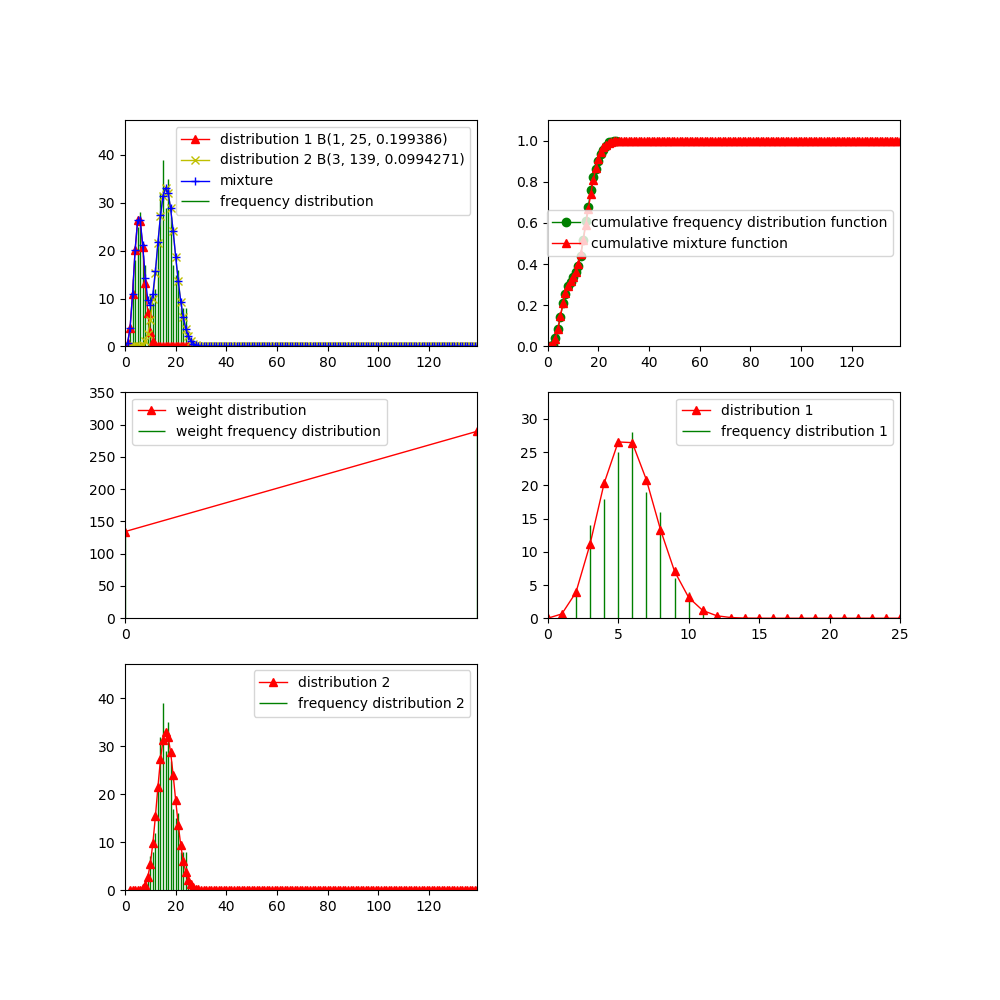

In [21]:
mixt = stat_tool.MixtureEstimation(meri0, 4, "BINOMIAL",
                                   display=True)
fig = mixt.plot()

## The **SequenceAnalysis** library

Once the wrapping of the **StatTool** library is performed, we need to compile and install the **SequenceAnalysis** library.
For this, we use the available **Conda** recipes.

In [22]:
subprocess.call('conda remove -y libsequence_analysis', shell=True)
CONDA_RECIPE = os.path.join(GIT_ROOT, 'share', 'git', 'StructureAnalysis', 'sequence_analysis', 'bin', 'conda',
                            'libsequence_analysis')
subprocess.check_call('conda build --python=' + PYTHON_VERSION + ' ' + CONDA_RECIPE + ' -c statiskit -c defaults --override-channels',
                      shell=True)
subprocess.check_call('conda install -y libsequence_analysis --use-local -c statiskit -c defaults --override-channels',
                      shell=True)

0

Then, we can proceed to the actual generation of wrappers for the **SequenceAnalysis** *C++* library.
In order to wrap a *C++* library that has dependencies, the user need to combine the ASGs resulting from the wrapping of its dependencies before performing its own wrapping.
For this, we create an empty Abstract Semantic Graph (ASG).

In [23]:
asg = autowig.AbstractSemanticGraph()

Then, we use the **pickle** *Python* package for de-serializing the **StatTool** ASG and merge it in the current ASG.

In [24]:
%%time

with open(os.path.join(GIT_ROOT, "share", "git", "StructureAnalysis", "stat_tool", "ASG.pkl"), "rb") as filehandler:
    asg.merge(pickle.load(filehandler))

CPU times: user 4.26 s, sys: 148 ms, total: 4.4 s
Wall time: 4.41 s


Then, we parse headers with relevant compilation flags.

In [25]:
%%time

if is_windows:
    headers = list((prefix/'include'/'sequence_analysis').walkfiles('*.h'))
else:
    headers = list((prefix/'include'/'sequence_analysis').walkfiles('*.h'))
    
flags = ['-x', 'c++', '-std=c++11', '-ferror-limit=0']
if is_windows:
    flags.append('-I' + str((prefix/'Library'/'include').abspath()))
else:
    flags.append('-I' + str((prefix/'include').abspath()))
    
asg = autowig.parser(asg, headers,
                          flags = flags,
                          bootstrap = 2,
                          **kwargs)

CPU times: user 2min 21s, sys: 1.22 s, total: 2min 23s
Wall time: 2min 23s


Since most of AutoWIG guidelines are respected, the default controller implementation could be suitable. Nevertheless, some errors induced by the `::sequence_analysis::Sequence::segment_profile_ascii_write` method lead us to implement a new controller.

Since most of AutoWIG guidelines are respected, the default controller implementation is suitable. 

In [26]:
%%time

asg = autowig.controller(asg)

CPU times: user 4.69 s, sys: 36 ms, total: 4.72 s
Wall time: 4.76 s


In order to wrap the library we need to select the `boost_python_internal` `generator` implementation.

In [27]:
%%time

autowig.generator.plugin = 'boost_python_internal'
wrappers = autowig.generator(asg,
                             module = os.path.join(GIT_ROOT, "share", "git", "StructureAnalysis",
                                                   "sequence_analysis", "src", "py", "wrapper",
                                                   "_sequence_analysis.cpp"),
                             decorator = os.path.join(GIT_ROOT, "share", "git", "StructureAnalysis",
                                                      "sequence_analysis", "src", "py", "sequence_analysis",
                                                      "_sequence_analysis.py"),
                             prefix = 'wrapper_')

CPU times: user 58.1 s, sys: 192 ms, total: 58.3 s
Wall time: 58.3 s


The wrappers are only generated in-memory.
It is therefore needed to write them on the disk to complete the process.

In [28]:
%%time

wrappers.write()

CPU times: user 3min 27s, sys: 10.2 s, total: 3min 37s
Wall time: 3min 49s


Here is the list of the generated wrappers (untracked files).

In [29]:
!git -C {REPO_DIR} status

HEAD detached at 51da8aec
Untracked files:
  (use "git add <file>..." to include in what will be committed)

	sequence_analysis/src/py/sequence_analysis/_sequence_analysis.py
	sequence_analysis/src/py/wrapper/_sequence_analysis.cpp
	sequence_analysis/src/py/wrapper/_sequence_analysis.h
	sequence_analysis/src/py/wrapper/wrapper_0439b61965155973ba96baf00c5b9a25.cpp
	sequence_analysis/src/py/wrapper/wrapper_07e3f88c5f5850088b1764909e61d1fa.cpp
	sequence_analysis/src/py/wrapper/wrapper_0ada3eb86d38586e9fd903acca98aae9.cpp
	sequence_analysis/src/py/wrapper/wrapper_0b30d1b45b0055c5ba5d29da37c2e844.cpp
	sequence_analysis/src/py/wrapper/wrapper_0caa9a9edbfe531693e099a4ba838734.cpp
	sequence_analysis/src/py/wrapper/wrapper_149a96c5a76159d385bb779a10bce4d1.cpp
	sequence_analysis/src/py/wrapper/wrapper_165ceb21150458369e358359e4e18a2e.cpp
	sequence_analysis/src/py/wrapper/wrapper_1b6e726737665f54a473d0b9e0593814.cpp
	sequence_analysis/src/py/wrapper/wrapper_20e69333984e5953bed91b7fa4baf27e.cpp
	s

Here is an example of the generated wrappers.

In [30]:
WRAPPER = os.path.join(GIT_ROOT, 'share', 'git', 'StructureAnalysis', 'sequence_analysis', 'src', 'py', 'wrapper',
                       '_sequence_analysis.cpp')
!pygmentize {WRAPPER}

#include "_sequence_analysis.h"

void wrapper_0439b61965155973ba96baf00c5b9a25();
void wrapper_07e3f88c5f5850088b1764909e61d1fa();
void wrapper_0ada3eb86d38586e9fd903acca98aae9();
void wrapper_0b30d1b45b0055c5ba5d29da37c2e844();
void wrapper_149a96c5a76159d385bb779a10bce4d1();
void wrapper_1b6e726737665f54a473d0b9e0593814();
void wrapper_212bbe2c11685cfdac78357c2883e49b();
void wrapper_21b15e21a9e1532295286ff7ffb9f04c();
void wrapper_2ec41346b3f65657910d348929a3a015();
void wrapper_3aec58e28df5595f960ec6d17989c8c3();
void wrapper_50690c42dfac58a0bdb747816552718c();
void wrapper_50cc285c539f5728a1506a0b95f57e1c();
void wrapper_51244fa815255257aee11f395bcd8eb5();
void wrapper_6d2234f6b2e758ec85504b36268f7fd2();
void wrapper_6f101b72a0c859cc9f60260f0a21fc1b();
void wrapper_73c9ca9e2968563791c82faddf6b1bc2();
void wrapper_78a1198538da5001a6339a522f35c40d();
void wrapper_98a72d1d4c9f5e7291db07d74c1c9e5b();
void wrapper_a05a2765cfaf5cd380199257281850f0();
void wrapper_a56a992dbd1c5fb2a9132a9

Once the wrappers are written on disk, we need to compile and install the *Python* bindings.
To do so, we use available **Conda** recipes.

In [31]:
subprocess.call('conda remove -y python-sequence_analysis', shell=True)
CONDA_RECIPE = os.path.join(GIT_ROOT, 'share', 'git', 'StructureAnalysis', 'sequence_analysis', 'bin', 'conda',
                            'python-sequence_analysis')
subprocess.check_call('conda build --python=' + PYTHON_VERSION + ' ' + CONDA_RECIPE + ' -c statiskit -c defaults --override-channels',
                      shell=True)
subprocess.check_call('conda install -y python-sequence_analysis --use-local -c statiskit -c defaults --override-channels',
                      shell=True)

0

Finally, we can hereafter use the *C++* library in the *Python* interpreter.

In [32]:
import sequence_analysis
%reload_ext sequence_analysis.mplotlib
%reload_ext sequence_analysis.aml

In [33]:
seq = sequence_analysis.Sequences(str(os.path.join(GIT_ROOT, "share", "git", "StructureAnalysis",
                                               "sequence_analysis", "share", "data",
                                                "well_log_filtered_indexed.seq")))

This last cell is by default not executed since the algorithm used is computer intensive.
To run this last cell, edit the metadata of the cell by switching the cell type from `Raw NBConvert` to `Code`.